# Stock Sentiment Analysis - Reddit vs the News

## 3. Data Processing for Modeling

#### Created By: Ben Chamblee - https://github.com/Bench-amblee

### Contents
- [Introduction](#introduction)
- [Imports](#imports)
- [Load Data](#load-data)
- [Aggregate Sentiment Scores](#aggregate-sentiment-scores)
- [Gathering Real Stock Data](#gathering-real-stock-data)
- [Aligning Stock Data and Sentiment Data](#aligning-stock-data-and-sentiment-data)
- [Additional Features](#additional-features)
- [Prepare Final Dataset for Modeling](#prepare-final-dataset-for-modeling)
- [Visualize and Export](#visualize-and-export)
- [Conclusion and Next Steps](#conclusion-and-next-steps)

<a id="introduction"></a>
### Introduction

This notebook documents the data processing methodologies employed to prepare our dataset for effective modeling. This phase focuses on transforming raw data into structured features that machine learning algorithms can effectively utilize.

The primary objectives of this notebook are to:

- Transform cleaned data into suitable formats for modeling
- Engineer features to capture sentiment patterns
- Apply appropriate scaling and normalization techniques
- Implement feature selection to identify the most predictive variables
- Validate processed data quality and distribution characteristics
- Generate the final modeling-ready datasets for machine learning experiments

<a id="imports"></a>
### Imports

In [2]:
import pandas as pd # Data manipulation library providing DataFrame structures
import numpy as np # Numerical computing library for mathematical operations and arrays
import matplotlib.pyplot as plt # Visualization library for creating graphs
import seaborn as sns # Statistical data visualization based on matplotlib
import yfinance as yf # Yahoo Finance API wrapper to download stock market data
from datetime import datetime, timedelta # For working with dates and times
import warnings # For handling warning messages
warnings.filterwarnings('ignore')

<a id="load-data"></a>
### Load Data

We will be loading the data from the previous notebook and reassesing the sentiment scores we calculated

In [3]:
# 1. Load the data
sentiment_data = pd.read_csv('../data/magnificent7_data/magnificent7_processed_data.csv')

<a id="aggregate-sentiment-scores"></a>
### Aggregate Sentiment Scores

We need to aggregates our scores by stock because there may be multiple posts about a stock per day and we want a consistent daily indicator to match up with daily stock prices. For our date range we'll do 1 year of stock data from March 1st 2024 to March 1st 2025.

In [4]:
# Convert date column to datetime and extract date part only
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])
sentiment_data['date_only'] = sentiment_data['date'].dt.date

# Define our date range
start_date = datetime(2024, 3, 1).date()
end_date = datetime(2025, 3, 1).date()

# Define our stock symbols
stocks = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]

# Filter to only include data from March 1, 2024 to March 1, 2025
filtered_data = sentiment_data[
    (sentiment_data['date_only'] >= start_date) & 
    (sentiment_data['date_only'] <= end_date)
]

Now we can see the averages for each sentiment measure for each platform and for each stock

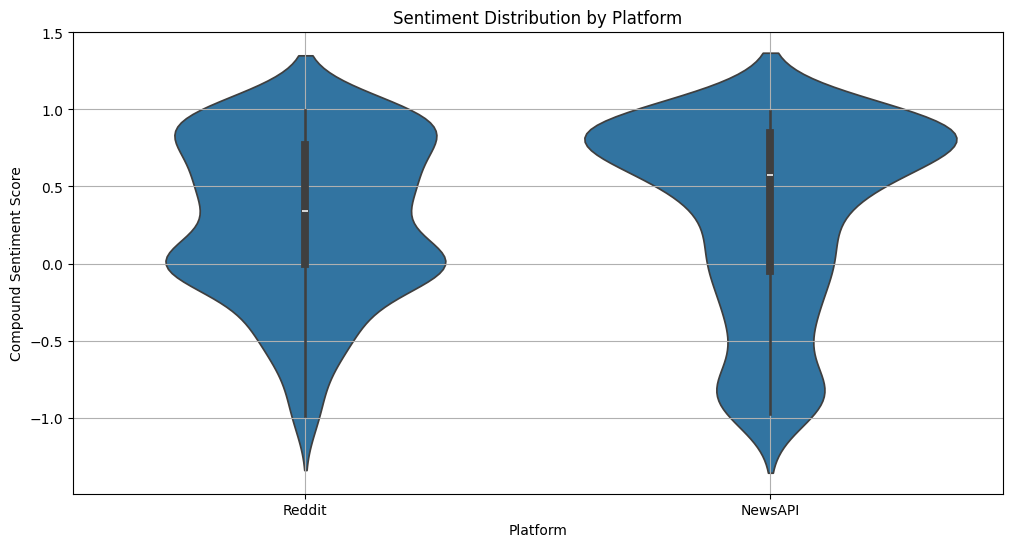

In [5]:
# Aggregate sentiment by stock and date
daily_sentiment = filtered_data.groupby(['stock_symbol', 'date_only']).agg({
    'sentiment_compound': 'mean',
    'sentiment_positive': 'mean',
    'sentiment_negative': 'mean',
    'sentiment_neutral': 'mean',
    'stock_symbol': 'count'  # Count of posts per day
}).rename(columns={'stock_symbol': 'post_count'})

# Reset index to make stock_symbol and date_only regular columns
daily_sentiment.reset_index(inplace=True)

# Aggregate sentiment by stock, platform, and date
platform_daily_sentiment = filtered_data.groupby(['stock_symbol', 'platform', 'date_only']).agg({
    'sentiment_compound': 'mean',
    'sentiment_positive': 'mean',
    'sentiment_negative': 'mean',
    'sentiment_neutral': 'mean',
    'stock_symbol': 'count'  # Count of posts per day
}).rename(columns={'stock_symbol': 'post_count'})

# Reset index
platform_daily_sentiment.reset_index(inplace=True)

# Compare sentiment distributions between platforms
plt.figure(figsize=(12, 6))
sns.violinplot(x='platform', y='sentiment_compound', data=filtered_data)
plt.title('Sentiment Distribution by Platform')
plt.xlabel('Platform')
plt.ylabel('Compound Sentiment Score')
plt.grid(True)
plt.show()

Again we're seeing that the news is generally more positive than reddit but reddit has a larger distribution of values - I wonder how this will impact which platform is more accurate for stock movement

In [6]:
# Calculate average sentiment by platform
platform_sentiment = filtered_data.groupby('platform').agg({
    'sentiment_compound': ['mean', 'std', 'count'],
    'sentiment_positive': 'mean',
    'sentiment_negative': 'mean'
})

print("\nAverage sentiment by platform:")
print(platform_sentiment)


Average sentiment by platform:
         sentiment_compound                 sentiment_positive  \
                       mean       std count               mean   
platform                                                         
NewsAPI            0.326861  0.616950   364           0.099868   
Reddit             0.290225  0.511062   203           0.095128   

         sentiment_negative  
                       mean  
platform                     
NewsAPI            0.046816  
Reddit             0.058261  


We will reference these values later when it comes to determining what each platform considers an upward movement, a downward movement, or a flat movement in the stock.

Reddit averages:
- compound sentiment: 0.290
- positive sentiment: 0.095
- negative sentiment: 0.058

News average:
- compound sentiment: 0.327
- positive sentiment: 0.099
- negative sentiment: 0.058

<a id="gathering real stock data"></a>
### Gathering Real Stock Data

Now lets source our stock data using the yfinance library. Let's get the prices for each of the magnificent 7 stocks from Mar 1st 2024 to March 1st 2025.

In [7]:
# Define the stock symbols
stocks = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]

# Fetch historical stock data
# Adding a day to end_date to include the end date in the data
stock_data = yf.download(
    " ".join(stocks),
    start=start_date,
    end=end_date + timedelta(days=1),
    group_by='ticker'
)

# Check the structure of the data
print(f"Stock data shape: {stock_data.shape}")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  7 of 7 completed

Stock data shape: (250, 35)


250 makes sense since no trading happens over the weekend or on certain holidays

The data will need some restructuring though to line up with our current sentiment dataframes

We're also going to add a price_direction field as a simple classifier, it will contain three values
- "up" if the stock's value has increased 0.5%
- "down" if the stock's value has decreased 0.5%
- "flat" if it's in the middle and hasn't moved by at least 0.5%

In [8]:
# Restructure the data to have each stock in separate rows
stock_prices = pd.DataFrame()

for stock in stocks:
    # Extract data for this stock
    stock_df = stock_data[stock].copy()
    stock_df['stock_symbol'] = stock
    stock_df.reset_index(inplace=True)
    stock_df.rename(columns={'Date': 'date'}, inplace=True)
    
    # Calculate daily returns
    stock_df['daily_return'] = (stock_df['Close'] - stock_df['Open']) / stock_df['Open'] * 100
    
    # Create price direction labels
    stock_df['price_direction'] = np.where(
        stock_df['daily_return'] > 0.5, 'up',
        np.where(stock_df['daily_return'] < -0.5, 'down', 'flat')
    )
    
    # Append to the combined dataframe
    stock_prices = pd.concat([stock_prices, stock_df])

# Convert date to datetime and date_only
stock_prices['date'] = pd.to_datetime(stock_prices['date'])
stock_prices['date_only'] = stock_prices['date'].dt.date

# Display the first few rows
stock_prices.head()

Price,date,Open,High,Low,Close,Volume,stock_symbol,daily_return,price_direction,date_only
0,2024-03-01,178.706175,179.681565,176.546375,178.815659,73488000,AAPL,0.061265,flat,2024-03-01
1,2024-03-04,175.322137,176.068613,172.973228,174.277084,81510100,AAPL,-0.596076,down,2024-03-04
2,2024-03-05,169.957487,171.231471,168.822845,169.320496,95132400,AAPL,-0.374795,flat,2024-03-05
3,2024-03-06,170.256065,170.435227,167.887245,168.325180,68587700,AAPL,-1.134106,down,2024-03-06
4,2024-03-07,168.355054,169.927630,167.698167,168.205765,71765100,AAPL,-0.088675,flat,2024-03-07


That looks great! Lets visualize how each stock has performed over the last year

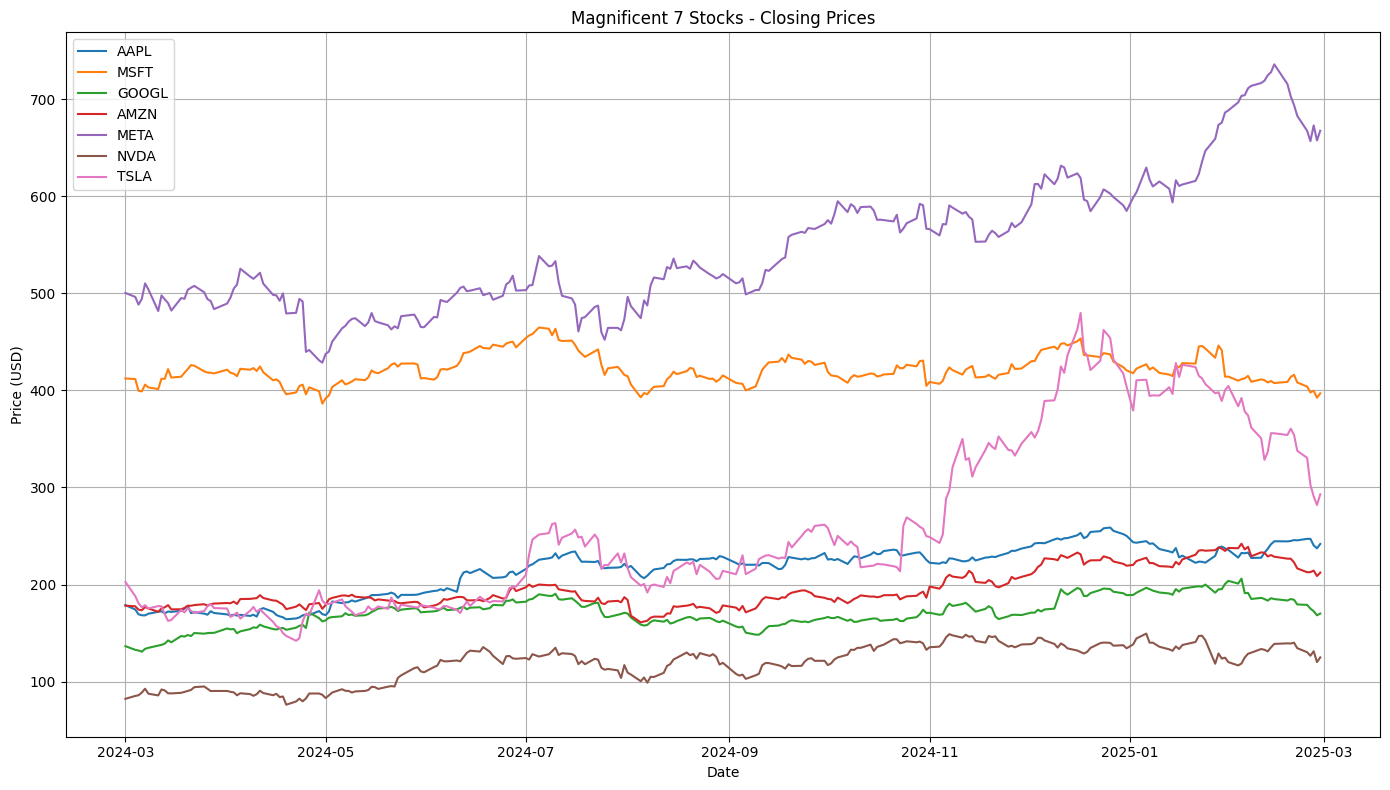

In [9]:
# Plot the closing prices for all stocks
plt.figure(figsize=(14, 8))
for stock in stocks:
    stock_subset = stock_prices[stock_prices['stock_symbol'] == stock]
    plt.plot(stock_subset['date'], stock_subset['Close'], label=stock)
plt.title('Magnificent 7 Stocks - Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

A lot of upward movement in general but also some huge crashes towards then end as well, I wonder which source will line up most with this

Now we have our two sources, we need to merge them and ensure they're processed for comparison and for modeling

<a id="aligning-stock-data-and-sentiment-data"></a>
### Aligning Stock Data and Sentiment Data

An important part of this step is to incorporate a lag feature - for example if someone posts on reddit on Monday it should impact what Reddit thinks will happen to the stock on Tuesday. Most of the news or reddit content is reactionary so if there was a big stock move there will be content reacting to it, we'll use the sentiment of that reaction as the basis for each platform's prediction.

In [ ]:
# Prepare for merging - ensure both date columns are datetime
daily_sentiment['date_only'] = pd.to_datetime(daily_sentiment['date_only'])
platform_daily_sentiment['date_only'] = pd.to_datetime(platform_daily_sentiment['date_only'])
stock_prices['date_only'] = pd.to_datetime(stock_prices['date_only'])

# First create a complete date range for each stock (including days with no sentiment)
# This ensures we have all trading days regardless of sentiment availability
all_dates = stock_prices[['stock_symbol', 'date_only']].drop_duplicates()

# Merge stock prices with sentiment data
combined_data = pd.merge(
    stock_prices,
    daily_sentiment,
    on=['stock_symbol', 'date_only'],
    how='left'
)

# Create a no_posts flag to identify days with no sentiment data
combined_data['no_posts'] = combined_data['post_count'].isnull()

# Now let's create platform-specific datasets
reddit_sentiment = platform_daily_sentiment[platform_daily_sentiment['platform'] == 'Reddit'].copy()
reddit_sentiment.drop(columns=['platform'], inplace=True)

news_sentiment = platform_daily_sentiment[platform_daily_sentiment['platform'] == 'NewsAPI'].copy()
news_sentiment.drop(columns=['platform'], inplace=True)

# Merge stock prices with platform-specific sentiment
# For Reddit
reddit_combined = pd.merge(
    stock_prices,
    reddit_sentiment,
    on=['stock_symbol', 'date_only'],
    how='left',
    suffixes=('', '_reddit')
)
reddit_combined['no_reddit_posts'] = reddit_combined['post_count'].isnull()

# For NewsAPI
news_combined = pd.merge(
    stock_prices,
    news_sentiment,
    on=['stock_symbol', 'date_only'],
    how='left',
    suffixes=('', '_news')
)
news_combined['no_news_articles'] = news_combined['post_count'].isnull()


Now let's add our day lag feature and also add some additional columns for modeling

- price_direction (up, down, or flat)
- daily_return (total % change)
- next_day_direction (1 if 'up', or 0 if not)

In [11]:
# Group by stock to ensure we don't leak data across stocks
combined_data_with_lags = pd.DataFrame()
reddit_data_with_lags = pd.DataFrame()
news_data_with_lags = pd.DataFrame()

for stock in stocks:
    # Process overall sentiment data
    stock_data = combined_data[combined_data['stock_symbol'] == stock].copy()
    
    # Sort by date
    stock_data = stock_data.sort_values('date_only')
    
    # Create lagged features - today's sentiment affects tomorrow's price
    stock_data['prev_day_sentiment_compound'] = stock_data['sentiment_compound'].shift(1)
    stock_data['prev_day_sentiment_positive'] = stock_data['sentiment_positive'].shift(1)
    stock_data['prev_day_sentiment_negative'] = stock_data['sentiment_negative'].shift(1)
    stock_data['prev_day_sentiment_neutral'] = stock_data['sentiment_neutral'].shift(1)
    stock_data['prev_day_post_count'] = stock_data['post_count'].shift(1)
    stock_data['prev_day_no_posts'] = stock_data['no_posts'].shift(1)
    
    # Create targets for next day's price movement
    stock_data['next_day_direction'] = stock_data['price_direction'].shift(-1)
    stock_data['next_day_return'] = stock_data['daily_return'].shift(-1)
    
    # Create binary target (1 if price goes up, 0 otherwise)
    stock_data['next_day_up'] = np.where(stock_data['next_day_direction'] == 'up', 1, 0)
    
    # Add to the combined data
    combined_data_with_lags = pd.concat([combined_data_with_lags, stock_data])
    
    # Process Reddit sentiment data
    reddit_stock_data = reddit_combined[reddit_combined['stock_symbol'] == stock].copy()
    reddit_stock_data = reddit_stock_data.sort_values('date_only')
    
    # Create lagged features for Reddit
    reddit_stock_data['prev_day_sentiment_compound'] = reddit_stock_data['sentiment_compound'].shift(1)
    reddit_stock_data['prev_day_sentiment_positive'] = reddit_stock_data['sentiment_positive'].shift(1)
    reddit_stock_data['prev_day_sentiment_negative'] = reddit_stock_data['sentiment_negative'].shift(1)
    reddit_stock_data['prev_day_sentiment_neutral'] = reddit_stock_data['sentiment_neutral'].shift(1)
    reddit_stock_data['prev_day_post_count'] = reddit_stock_data['post_count'].shift(1)
    reddit_stock_data['prev_day_no_reddit_posts'] = reddit_stock_data['no_reddit_posts'].shift(1)
    
    # Create same targets
    reddit_stock_data['next_day_direction'] = reddit_stock_data['price_direction'].shift(-1)
    reddit_stock_data['next_day_return'] = reddit_stock_data['daily_return'].shift(-1)
    reddit_stock_data['next_day_up'] = np.where(reddit_stock_data['next_day_direction'] == 'up', 1, 0)
    
    # Add to Reddit data
    reddit_data_with_lags = pd.concat([reddit_data_with_lags, reddit_stock_data])
    
    # Process NewsAPI sentiment data
    news_stock_data = news_combined[news_combined['stock_symbol'] == stock].copy()
    news_stock_data = news_stock_data.sort_values('date_only')
    
    # Create lagged features for NewsAPI
    news_stock_data['prev_day_sentiment_compound'] = news_stock_data['sentiment_compound'].shift(1)
    news_stock_data['prev_day_sentiment_positive'] = news_stock_data['sentiment_positive'].shift(1)
    news_stock_data['prev_day_sentiment_negative'] = news_stock_data['sentiment_negative'].shift(1)
    news_stock_data['prev_day_sentiment_neutral'] = news_stock_data['sentiment_neutral'].shift(1)
    news_stock_data['prev_day_post_count'] = news_stock_data['post_count'].shift(1)
    news_stock_data['prev_day_no_news_articles'] = news_stock_data['no_news_articles'].shift(1)
    
    # Create same targets
    news_stock_data['next_day_direction'] = news_stock_data['price_direction'].shift(-1)
    news_stock_data['next_day_return'] = news_stock_data['daily_return'].shift(-1)
    news_stock_data['next_day_up'] = np.where(news_stock_data['next_day_direction'] == 'up', 1, 0)
    
    # Add to NewsAPI data
    news_data_with_lags = pd.concat([news_data_with_lags, news_stock_data])

# Check the resulting data
print(f"Combined data shape: {combined_data_with_lags.shape}")
print(f"Reddit data shape: {reddit_data_with_lags.shape}")
print(f"NewsAPI data shape: {news_data_with_lags.shape}")

Combined data shape: (1750, 25)
Reddit data shape: (1750, 25)
NewsAPI data shape: (1750, 25)


Now we need to address gaps in our sentiment data, while we do have coverage for the entire year, we don't have daily information for each stock for each day. So we're going to fill in the gaps using this logic:

For days where there are no sentiment data, the assumed sentiment will match the most recent sentiment value until another post is found.

For example, If there's a positive sentiment Reddit post about Apple on Monday 7/15 and there are no other Reddit posts about Apple until 7/18 - we will assume that the sentiment on Apple is positive the entire time.

We're doing this to create a matching "up", "down", "flat" predicted feature that we can use as part of our classification analysis. So every day there's a stock movement there is a corresponding reddit/news previous day prediction to match it up to.

fill_missing_sentiment fills missing sentiment values for each stock:
- Creates a copy of the original DataFrame
- Processes each stock separately
- For each sentiment column (compound, positive, negative, neutral) and count columns:
    - First tries forward fill (using previous day's values)
    - If still missing, uses the column's mean or 0 if all values are missing
- Creates new "_filled" columns with the complete data
- Adds "_is_filled" indicator columns to track which values were originally missing

Finally, we return to our platform average sentiment values, based on the earlier mean calculations we determine if Reddit or the News thinks the stock will go up, down, or flat.

- If the sentiment compound value is greater than 0.2 - we think the stock will go "up"
- If the sentiment compound value is less than -0.05 - we think the stock will go "down"
- If the sentiment compound value is between -0.05 and 0.2 - we think the stock will be "flat"

In [12]:
# Modified function to fill missing sentiment values by stock
def fill_missing_sentiment(df, no_post_column=None):
    # Create a copy to avoid warnings
    result_df = df.copy()
    
    # For each stock, fill missing values
    for stock in stocks:
        stock_mask = result_df['stock_symbol'] == stock
        stock_df = result_df[stock_mask]
        
        # Forward fill (use previous day's sentiment)
        for col in ['sentiment_compound', 'sentiment_positive', 'sentiment_negative', 'sentiment_neutral', 'post_count',
                   'prev_day_sentiment_compound', 'prev_day_sentiment_positive', 'prev_day_sentiment_negative', 
                   'prev_day_sentiment_neutral', 'prev_day_post_count']:
            # First try forward fill
            filled_values = stock_df[col].fillna(method='ffill')
            
            # If still missing (beginning of series), use mean
            if filled_values.isnull().any():
                mean_val = stock_df[col].mean()
                if pd.isnull(mean_val):  # If mean is also NaN (all values missing)
                    mean_val = 0
                filled_values = filled_values.fillna(mean_val)
            
            # Update the values
            result_df.loc[stock_mask, f'{col}_filled'] = filled_values
            
            # Create indicator for filled values
            result_df.loc[stock_mask, f'{col}_is_filled'] = stock_df[col].isnull()
    
    # Special handling for days with no posts - maintain last known sentiment direction
    if no_post_column is not None:
        # Fill any NaN values in the column to avoid masking errors
        result_df[no_post_column] = result_df[no_post_column].fillna(False)
        
        # For days with no posts (previous day), we'll create prediction flags
        result_df[f'no_post_prediction'] = result_df[no_post_column]
        
        # For these days, we'll carry forward the last direction prediction based on sentiment
        # First create a predicted direction based on sentiment
        result_df['sentiment_direction'] = 'neutral'  # Default
        
        # If sentiment is positive (> 0.1), predict "up"
        result_df.loc[result_df['prev_day_sentiment_compound_filled'] > 0.2, 'sentiment_direction'] = 'up'
        
        # If sentiment is negative (< -0.05), predict "down"
        result_df.loc[result_df['prev_day_sentiment_compound_filled'] < -0.05, 'sentiment_direction'] = 'down'
        
        # If sentiment is neutral (between -0.2 and 0.2), predict "flat"
        result_df.loc[(result_df['prev_day_sentiment_compound_filled'] >= -0.05) & 
                     (result_df['prev_day_sentiment_compound_filled'] <= 0.2), 'sentiment_direction'] = 'flat'
        
        
        # For no-post days, use the sentiment-based direction instead
        result_df.loc[result_df[no_post_column], f'predicted_direction'] = result_df.loc[result_df[no_post_column], 'sentiment_direction']
    
    return result_df

# Apply the function to fill missing values for each dataset with the appropriate no-post column
data_filled = fill_missing_sentiment(combined_data_with_lags, 'prev_day_no_posts')
reddit_data_filled = fill_missing_sentiment(reddit_data_with_lags, 'prev_day_no_reddit_posts')
news_data_filled = fill_missing_sentiment(news_data_with_lags, 'prev_day_no_news_articles')

Now let's see how our predictions look for each platform

In [13]:
# Add platform identifier columns for future analysis
data_filled['data_source'] = 'combined'
reddit_data_filled['data_source'] = 'reddit' 
news_data_filled['data_source'] = 'news'

# Count sentiment direction distribution for no-post days
sentiment_pred_combined = data_filled[data_filled['no_post_prediction']]['sentiment_direction'].value_counts()
sentiment_pred_reddit = reddit_data_filled[reddit_data_filled['no_post_prediction']]['sentiment_direction'].value_counts()
sentiment_pred_news = news_data_filled[news_data_filled['no_post_prediction']]['sentiment_direction'].value_counts()

print("\nSentiment-based direction for no-post days:")
if len(sentiment_pred_combined) > 0:
    print('Combined')
    print(sentiment_pred_combined / sentiment_pred_combined.sum() * 100)
    print('Reddit')
    print(sentiment_pred_reddit / sentiment_pred_reddit.sum() * 100)
    print('NewsAPI')
    print(sentiment_pred_news / sentiment_pred_news.sum() * 100)


Sentiment-based direction for no-post days:
Combined
sentiment_direction
up      60.801144
down    24.391989
flat    14.806867
Name: count, dtype: float64
Reddit
sentiment_direction
up      45.895522
down    31.343284
flat    22.761194
Name: count, dtype: float64
NewsAPI
sentiment_direction
up      61.279683
down    29.617414
flat     9.102902
Name: count, dtype: float64


As expected, we see that the news is more positive than Reddit. Interestingly enough, both platforms are pretty equal for % of "down" predictions, its really just the % of "flat" predictions that are making a big difference

<a id="additional-features"></a>
### Additional Features

Before we start doing a direct comparison, lets add some additional features to our dataset. Things like "day of the week", "end of a quarter", and "7day sentiment average" might show some interesting trends so we'll include them for modeling

In [14]:
# Create additional features
def create_additional_features(df):
    # Create a copy
    result_df = df.copy()
    
    # Add calendar features
    result_df['day_of_week'] = result_df['date'].dt.dayofweek
    result_df['month'] = result_df['date'].dt.month
    result_df['is_quarter_end'] = result_df['date'].dt.is_quarter_end
    
    # Add volatility features (high-low range as percentage of open)
    result_df['volatility'] = (result_df['High'] - result_df['Low']) / result_df['Open'] * 100
    
    # Calculate 7-day rolling averages for sentiment
    for stock in stocks:
        stock_mask = result_df['stock_symbol'] == stock
        # Sort by date for proper rolling window
        stock_df = result_df[stock_mask].sort_values('date')
        
        # Calculate rolling sentiment
        result_df.loc[stock_mask, 'sentiment_7day_avg'] = stock_df['sentiment_compound_filled'].rolling(7, min_periods=1).mean()
    
    return result_df

# Apply additional feature creation to all datasets
final_data = create_additional_features(data_filled)
reddit_final_data = create_additional_features(reddit_data_filled)
news_final_data = create_additional_features(news_data_filled)

# Display the enhanced data
print("\nSample of enhanced data with additional features:")
final_data[['stock_symbol', 'date_only', 'sentiment_compound_filled', 
                  'day_of_week', 'month', 'volatility', 'sentiment_7day_avg']].head()


Sample of enhanced data with additional features:


,stock_symbol,date_only,sentiment_compound_filled,day_of_week,month,volatility,sentiment_7day_avg
0,AAPL,2024-03-01,0.191961,4,3,1.754383,0.191961
1,AAPL,2024-03-04,0.191961,0,3,1.765541,0.191961
2,AAPL,2024-03-05,0.191961,1,3,1.417193,0.191961
3,AAPL,2024-03-06,0.191961,2,3,1.496558,0.191961
4,AAPL,2024-03-07,0.552400,3,3,1.324263,0.264049


<a id="prepare-final-dataset-for-modeling"></a>
### Prepare Final Dataset for Modeling

Now that we have our sentiment data, our stock data, and additional features we can get our dataset set up for modeling by isolating which columns we want to predict and which columns we can use as features. 

In [ ]:
# Drop last day for each stock (no next_day_direction)
final_data = final_data.dropna(subset=['next_day_direction'])
reddit_final_data = reddit_final_data.dropna(subset=['next_day_direction'])
news_final_data = news_final_data.dropna(subset=['next_day_direction'])

# Select relevant columns for modeling
modeling_columns = [
    'stock_symbol', 'date_only', 'data_source',
    'Open', 'High', 'Low', 'Close', 'Volume', 'daily_return',
    
    # Sentiment features (use filled values)
    'sentiment_compound_filled', 'sentiment_positive_filled', 
    'sentiment_negative_filled', 'sentiment_neutral_filled',
    
    # Sentiment lag features
    'prev_day_sentiment_compound_filled', 'prev_day_sentiment_positive_filled', 
    'prev_day_sentiment_negative_filled', 'prev_day_sentiment_neutral_filled',
    
    # Indicator for filled values
    'sentiment_compound_is_filled', 'prev_day_sentiment_compound_is_filled',
    
    # No post indicators
    'no_post_prediction',
    
    # Post counts
    'post_count_filled', 'prev_day_post_count_filled',
    
    # Additional features
    'day_of_week', 'month', 'is_quarter_end', 'volatility', 'sentiment_7day_avg',
    
    # Target variables
    'next_day_direction', 'predicted_direction', 'next_day_up', 'next_day_return'
]

# Create final datasets
model_data = final_data[modeling_columns].copy()
reddit_model_data = reddit_final_data[modeling_columns].copy()
news_model_data = news_final_data[modeling_columns].copy()

# Combine them into a single dataset for easier comparison
combined_model_data = pd.concat([model_data, reddit_model_data, news_model_data])

# Check the shape of the final datasets
print(f"\nFinal combined dataset shape: {model_data.shape}")
print(f"Final Reddit dataset shape: {reddit_model_data.shape}")
print(f"Final NewsAPI dataset shape: {news_model_data.shape}")
print(f"Combined comparison dataset shape: {combined_model_data.shape}")


Final combined dataset shape: (1743, 31)
Final Reddit dataset shape: (1743, 31)
Final NewsAPI dataset shape: (1743, 31)
Combined comparison dataset shape: (5229, 31)


<a id="visualize-and-export"></a>
### Visualize and Export

Now that our data is ready for export, lets make a quick visual on the monthly sentiment using the logic from our processing script. We'll take a look at the combined sentiment and then the sentiment from the news and Reddit seperately

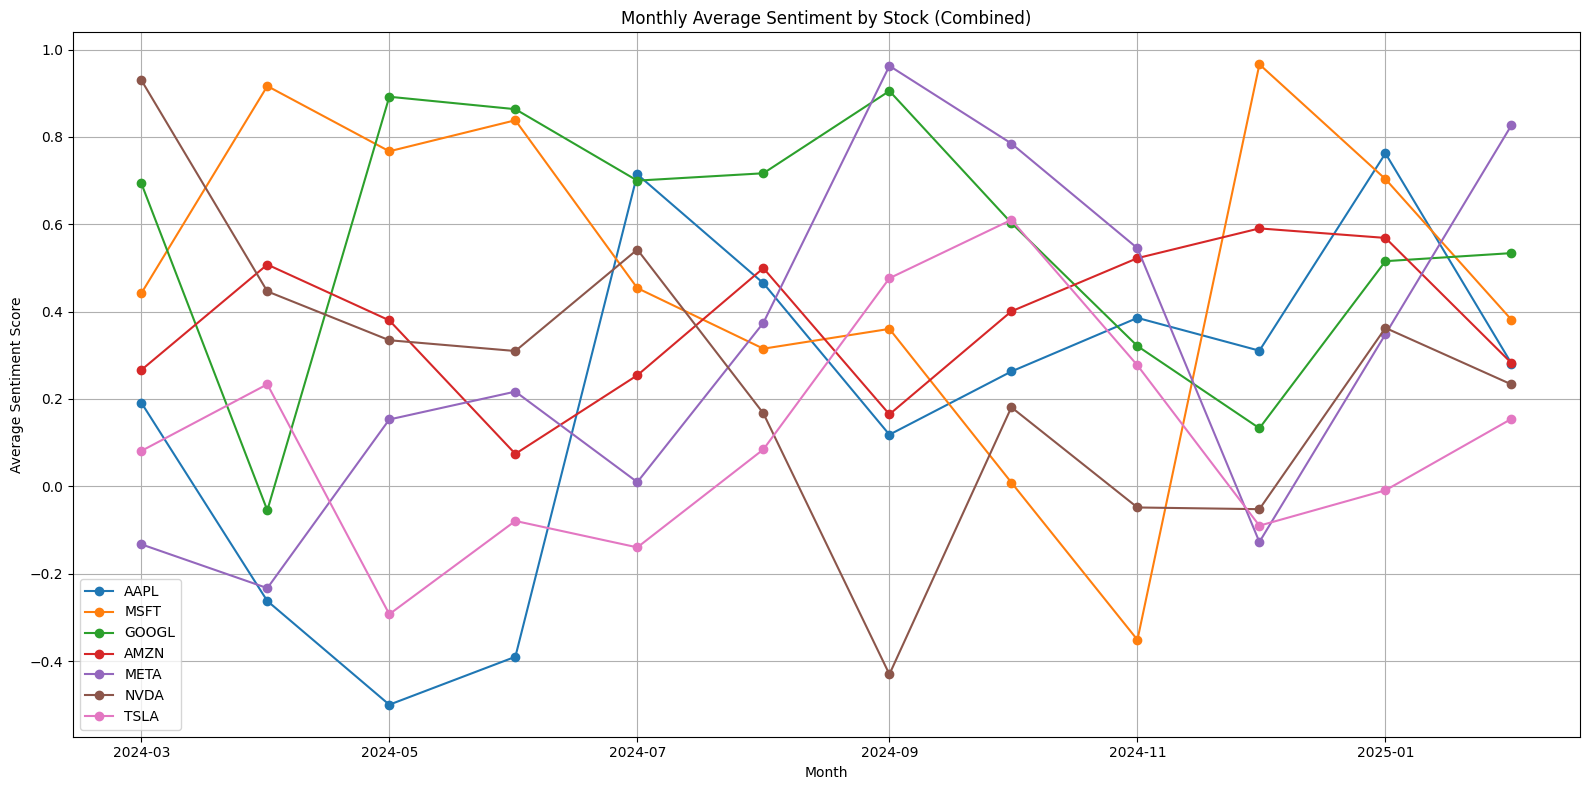

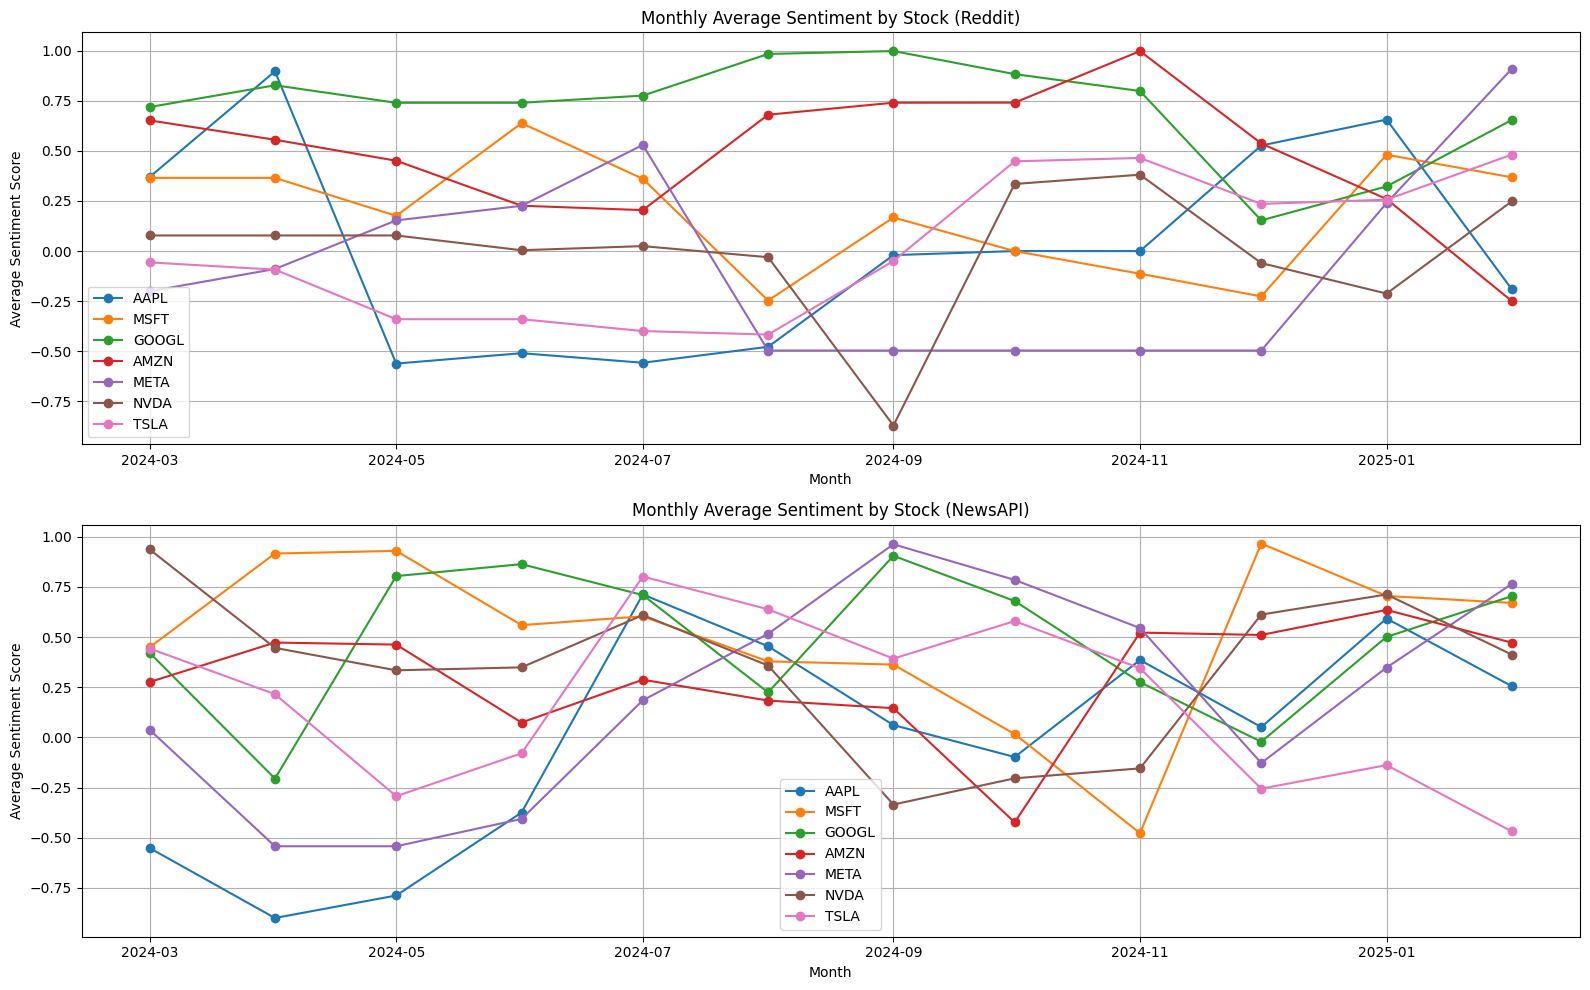

In [ ]:
# Plot: Average sentiment over time by platform
# Create a date index for plotting
model_data['month_year'] = pd.to_datetime(model_data['date_only']).dt.to_period('M')
reddit_model_data['month_year'] = pd.to_datetime(reddit_model_data['date_only']).dt.to_period('M')
news_model_data['month_year'] = pd.to_datetime(news_model_data['date_only']).dt.to_period('M')

# Calculate monthly average sentiment
monthly_sentiment_combined = model_data.groupby(['stock_symbol', 'month_year']).agg({
    'sentiment_compound_filled': 'mean',
    'next_day_return': 'mean'
}).reset_index()

monthly_sentiment_reddit = reddit_model_data.groupby(['stock_symbol', 'month_year']).agg({
    'sentiment_compound_filled': 'mean',
    'next_day_return': 'mean'
}).reset_index()

monthly_sentiment_news = news_model_data.groupby(['stock_symbol', 'month_year']).agg({
    'sentiment_compound_filled': 'mean',
    'next_day_return': 'mean'
}).reset_index()

# Convert period to datetime for plotting
monthly_sentiment_combined['month_year'] = monthly_sentiment_combined['month_year'].dt.to_timestamp()
monthly_sentiment_reddit['month_year'] = monthly_sentiment_reddit['month_year'].dt.to_timestamp()
monthly_sentiment_news['month_year'] = monthly_sentiment_news['month_year'].dt.to_timestamp()

# Plot sentiment trends - Combined
plt.figure(figsize=(16, 8))
for stock in stocks:
    stock_data = monthly_sentiment_combined[monthly_sentiment_combined['stock_symbol'] == stock]
    plt.plot(stock_data['month_year'], stock_data['sentiment_compound_filled'], marker='o', label=stock)
plt.title('Monthly Average Sentiment by Stock (Combined)')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot sentiment trends - Reddit vs News
plt.figure(figsize=(16, 10))

# First Reddit
plt.subplot(2, 1, 1)
for stock in stocks:
    stock_data = monthly_sentiment_reddit[monthly_sentiment_reddit['stock_symbol'] == stock]
    plt.plot(stock_data['month_year'], stock_data['sentiment_compound_filled'], marker='o', label=stock)
plt.title('Monthly Average Sentiment by Stock (Reddit)')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.grid(True)

# Then NewsAPI
plt.subplot(2, 1, 2)
for stock in stocks:
    stock_data = monthly_sentiment_news[monthly_sentiment_news['stock_symbol'] == stock]
    plt.plot(stock_data['month_year'], stock_data['sentiment_compound_filled'], marker='o', label=stock)
plt.title('Monthly Average Sentiment by Stock (NewsAPI)')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Just by looking at the sentiment for Tesla, I can see that NewsAPI might be more accurate. We'll have to wait and see though as we move on the modeling notebook!

In [ ]:
# Save the final datasets
model_data.to_csv('../data/magnificent7_data/stock_sentiment_model_data.csv', index=False)
reddit_model_data.to_csv('../data/magnificent7_data/reddit_sentiment_model_data.csv', index=False)
news_model_data.to_csv('../data/magnificent7_data/news_sentiment_model_data.csv', index=False)
combined_model_data.to_csv('../data/magnificent7_data/combined_comparison_data.csv', index=False)

<a id="conclusion-and-next-steps"></a>
### Conclusion and Next Steps

This notebook successfully processes our sentiment data from the previous notebook and incorporates additional features like predicted movement (up, down, or flat), 7 day moving average, and other features like day of the week and quarter end. In addition to this, this notebook has merged our sentiment dataset with real stock data for comparison and modeling. Our data has been exported with features selected for testing and for making predictions

#### Next Steps

Modeling

- Use processed dataset to establish a baseline model
- Create a train/test split and test various models
- Once a model is selected, analyze the results and make any improvements
- Use model to determine accuracy for both platforms and compare
- Add features or modeling techniques to imporve overall accuracy
- Consider deployment and scalability for future usage

The modeling notebook will transofmr our dataset into a working data model that will allow us to predict stock movement using Reddit and News data, first we'll see which one is more accurate and then we can see if we can achieve greater accuracy by using both sources.